In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We download the dataset when the notebook starts, because it's no longer in the local session

In [ ]:
if not os.path.exists('./hotdog_nothotdog'):
  import gdown
  url = 'https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk'
  gdown.download(url, './hotdog_nothotdog.zip', quiet=False)
  !unzip ./hotdog_nothotdog.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk
To: /content/hotdog_nothotdog.zip
271MB [00:01, 194MB/s]


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use

In [ ]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        print
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
trainset.__len__()

2047

In [ ]:
testset.__len__()

Let's look at some images from our data 

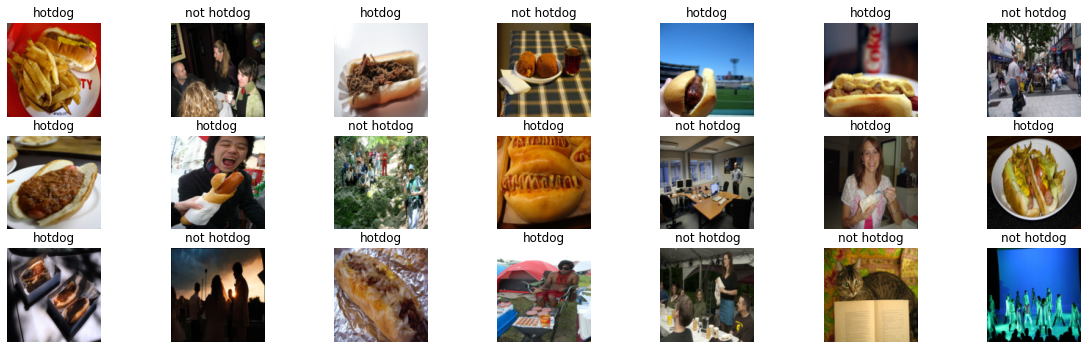

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Now create a model and train it!


In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target) # logsoftmax and nll included
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
            
        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [ ]:
class VGG(nn.Module):
    def __init__(self, n_in, n_f):
        super(VGG, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=n_in, out_channels=n_f, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_f, out_channels=n_f, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=n_f, out_channels=n_f*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_f*2, out_channels=n_f*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=n_f*2, out_channels=n_f*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_f*4, out_channels=n_f*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(16*16*(n_f*4), 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            # nn.Softmax(dim=1),
            # nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout2d(),
            nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, stride=1, padding=1),
        )
    def forward(self, x):
        residual = x
        out = self.convolutional(x)
        out = out + residual
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_f1, n_f2, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers1 = [nn.Conv2d(n_in, n_f1, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(n_f1),
                        nn.Dropout2d(),
                        nn.MaxPool2d(2),
                        ]
        for i in range(num_res_blocks):
            conv_layers1.append(ResNetBlock(n_f1))
        self.res_blocks1 = nn.Sequential(*conv_layers1)
        conv_layers2 = [nn.Conv2d(n_f1, n_f2, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(n_f2),
                        nn.Dropout2d(),
                        nn.MaxPool2d(2),
                        ]
        for i in range(num_res_blocks):
            conv_layers2.append(ResNetBlock(n_f2))
        self.res_blocks2 = nn.Sequential(*conv_layers2)
        
        self.fc = nn.Sequential(nn.Linear(32*32*n_f2, 4096, bias=False),
                                nn.ReLU(),
                                nn.Linear(4096, 256, bias=False),
                                nn.ReLU(),
                                nn.Linear(256, 2),
                                )
        
    def forward(self, x):
        x = self.res_blocks1(x)
        x = self.res_blocks2(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

In [ ]:
model = VGG(3, 32)
model.to(device)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_sdg_vgg = train(model, optimizer)

In [ ]:
model = ResNet(3, 16, 32)
model.to(device)

ResNet(
  (res_blocks1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ResNetBlock(
      (convolutional): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (6): ResNetBlock(
      (convolutional): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (7): ResNetBlock(
      (convolutional): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
     

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_sdg = train(model, optimizer)


Loss train: 0.797	 test: 0.693	 Accuracy train: 53.6%	 test: 48.1%



Loss train: 0.653	 test: 0.630	 Accuracy train: 62.2%	 test: 65.4%



Loss train: 0.622	 test: 0.634	 Accuracy train: 68.2%	 test: 67.2%



Loss train: 0.586	 test: 0.576	 Accuracy train: 71.0%	 test: 72.7%



Loss train: 0.568	 test: 0.648	 Accuracy train: 72.4%	 test: 63.9%



Loss train: 0.542	 test: 0.570	 Accuracy train: 75.0%	 test: 69.6%



Loss train: 0.520	 test: 0.540	 Accuracy train: 76.2%	 test: 73.7%



Loss train: 0.505	 test: 0.565	 Accuracy train: 76.3%	 test: 70.6%



Loss train: 0.494	 test: 0.537	 Accuracy train: 76.6%	 test: 72.5%



Loss train: 0.464	 test: 0.529	 Accuracy train: 78.5%	 test: 74.4%



In [ ]:
optimizer = torch.optim.Adam(model.parameters())
out_adam = train(model, optimizer)

In [ ]:
img = torch.randn((1,3,128,128), requires_grad=True)
test = img.detach().numpy().copy()
model.to('cpu')
opt = torch.optim.Adam([img])

for t in range(30):
    pred = model(img)
    loss = F.nll_loss(pred, torch.tensor([1]))
    if t % 5 == 0:
        print(t, loss.item())
        if t > 0:
            print(pred == pred_old)
            
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    pred_old = pred

print("True class probability:", nn.Softmax(dim=1)(pred))

0 -787.558349609375
5 -988.892333984375
tensor([[False, False]])
10 -1185.0093994140625
tensor([[False, False]])
15 -1371.7164306640625
tensor([[False, False]])
20 -1556.6944580078125
tensor([[False, False]])
25 -1733.7940673828125
tensor([[False, False]])
True class probability: tensor([[0., 1.]], grad_fn=<SoftmaxBackward>)


In [ ]:
img_after = img.detach().numpy()
img_after.sum() == test.sum()

False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


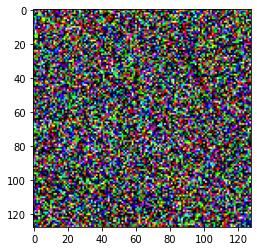

In [ ]:
plt.imshow(np.swapaxes(np.swapaxes(test.squeeze(), 0, 2), 0, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


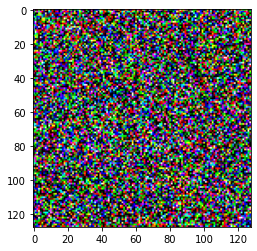

In [ ]:
plt.imshow(np.swapaxes(np.swapaxes(img_after.squeeze(), 0, 2), 0, 1))

In [ ]:
F.softmax(pred, dim=1)[0,0].item()

8.96831017167883e-44

Text(0, 0.5, 'Error')

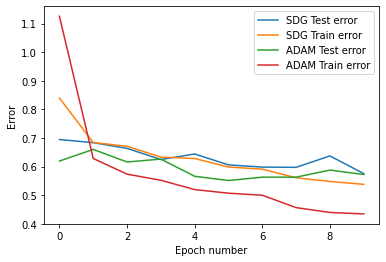

In [ ]:
# Loss
plt.plot(range(10), out_sdg['test_loss'])
plt.plot(range(10), out_sdg['train_loss'])
plt.plot(range(10), out_adam['test_loss'])
plt.plot(range(10), out_adam['train_loss'])
plt.legend(('SDG Test error','SDG Train error', 'ADAM Test error', 'ADAM Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Error')

Text(0, 0.5, 'Accuracy')

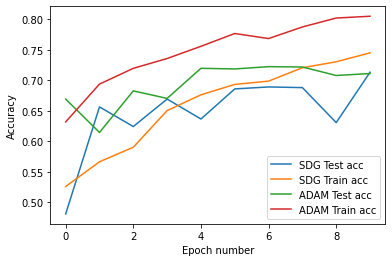

In [ ]:
# Accuracy
plt.plot(range(10), out_sdg['test_acc'])
plt.plot(range(10), out_sdg['train_acc'])
plt.plot(range(10), out_adam['test_acc'])
plt.plot(range(10), out_adam['train_acc'])
plt.legend(('SDG Test acc','SDG Train acc', 'ADAM Test acc', 'ADAM Train acc'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')